In [1]:
import huggingface_hub
if not hasattr(huggingface_hub, "cached_download"):
    from huggingface_hub import hf_hub_download
    huggingface_hub.cached_download = hf_hub_download

import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
from safetensors.torch import load_file
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
# your classes
from flownet import DualFlowControlNet
from pipeline import StableDiffusionDualFlowControlNetPipeline

/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/data/maryamsana_98/anaconda3/envs/diffusers_env/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::fla

In [2]:
# ---------------------------
# Helpers: image & .flo loaders
# ---------------------------
def read_flo(path: str) -> np.ndarray:
    """Middlebury .flo → [H,W,2] float32 (pixel units)."""
    with open(path, "rb") as f:
        magic = np.fromfile(f, np.float32, 1)[0]
        if magic != 202021.25:
            raise ValueError(f"Invalid .flo file: {path} (magic={magic})")
        w = int(np.fromfile(f, np.int32, 1)[0])
        h = int(np.fromfile(f, np.int32, 1)[0])
        data = np.fromfile(f, np.float32, 2 * w * h).reshape(h, w, 2)
    return data

def resize_flow_to(flow_hw2: np.ndarray, target_h: int, target_w: int) -> torch.Tensor:
    """Resize flow with bilinear and scale vectors to remain in pixel units."""
    ft = torch.from_numpy(flow_hw2).permute(2, 0, 1).unsqueeze(0)  # [1,2,H,W]
    _, _, H, W = ft.shape
    ft = F.interpolate(ft, size=(target_h, target_w), mode="bilinear", align_corners=True)
    ft[:, 0] *= (target_w / max(W, 1))
    ft[:, 1] *= (target_h / max(H, 1))
    return ft  # [1,2,target_h,target_w]

def load_pair_to_sixch(path0, path1, size=(512, 512)) -> torch.Tensor:
    """Two RGB images → [1,6,H,W] in [0,1]."""
    def load_rgb(p):
        img = Image.open(p).convert("RGB")
        if size is not None:
            img = img.resize(size, Image.BICUBIC)
        return TF.to_tensor(img)  # [3,H,W], float32
    a = load_rgb(path0)
    b = load_rgb(path1)
    return torch.cat([a, b], dim=0).unsqueeze(0)  # [1,6,H,W]

def load_controls_and_flows(
    img0_path, img1_path, fwd_flo_path, bwd_flo_path, size=(512, 512), device="cuda", dtype=torch.float32
):
    H, W = size
    sixch = load_pair_to_sixch(img0_path, img1_path, size=size).to(device=device, dtype=dtype)  # [1,6,H,W]

    fwd = read_flo(fwd_flo_path)
    bwd = read_flo(bwd_flo_path)
    fwd_t = resize_flow_to(fwd, H, W)
    bwd_t = resize_flow_to(bwd, H, W)
    flow4 = torch.cat([fwd_t, bwd_t], dim=1).to(device=device, dtype=dtype)  # [1,4,H,W]
    return sixch, flow4


In [3]:
device = "cuda"
dtype  = torch.float32 
# ---------------------------
# Load controls
# ---------------------------
sixch, flow4 = load_controls_and_flows(
    "data/Bosphorus/images/frame_0000.png",
    "data/Bosphorus/images/frame_0004.png",
    "data/Bosphorus/optical_flow/optical_flow_gop_4_raft/flow_0000_0003.flo",
    "data/Bosphorus/optical_flow_bwd/optical_flow_gop_4_raft/flow_0004_0003.flo",
    size=(512, 512),
    device=device,
    dtype=dtype,
)

In [4]:
vae = AutoencoderKL.from_pretrained(
    "stabilityai/sdxl-vae",     # official HF repo
    torch_dtype=dtype
)

In [7]:
# ---------------------------
# Load models (aligned SD-1.5)
# ---------------------------
base = "stable-diffusion-v1-5/stable-diffusion-v1-5"

vae = AutoencoderKL.from_pretrained(base, subfolder="vae", torch_dtype=dtype)
unet = UNet2DConditionModel.from_pretrained(base, subfolder="unet", torch_dtype=dtype)
text_encoder = CLIPTextModel.from_pretrained(base, subfolder="text_encoder", torch_dtype=dtype)
tokenizer = CLIPTokenizer.from_pretrained(base, subfolder="tokenizer")
scheduler = UniPCMultistepScheduler.from_pretrained(base, subfolder="scheduler")

# --- ControlNet: load your subclass weights ---
controlnet = DualFlowControlNet(
    block_out_channels=tuple(unet.config.block_out_channels),     # (320, 640, 1280, 1280)
    layers_per_block=2,
    cross_attention_dim=768,   
 )
# controlnet.load_state_dict(torch.load("path/to/controlnet.safetensors" or ".pth", map_location="cpu"))

# sanity: cross-attn dims must match (768 for SD1.x)
assert unet.config.cross_attention_dim == text_encoder.config.hidden_size == 768
if hasattr(controlnet, "config") and hasattr(controlnet.config, "cross_attention_dim"):
    assert controlnet.config.cross_attention_dim == 768, f"ControlNet CAD={controlnet.config.cross_attention_dim}"

ckpt = load_file('experiments/controlnet/checkpoint-139000/controlnet/diffusion_pytorch_model.safetensors')
controlnet.load_state_dict(ckpt,strict=False)

<All keys matched successfully>

In [9]:
safety_checker = None
feature_extractor = None

# ---------------------------
# Build pipeline
# ---------------------------
pipe = StableDiffusionDualFlowControlNetPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    controlnet=controlnet,
    scheduler=scheduler,
    safety_checker=safety_checker,
    feature_extractor=feature_extractor,
)
# pipe = pipe.to("cuda")

In [18]:
prompt = "photograph of a woman with blonde hair, soft lighting, sharp focus, high detail , has pink lipstick and is infront of black background"
g = torch.Generator(device=device).manual_seed(42)  

In [7]:
del vae, tokenizer,unet, controlnet

torch.cuda.empty_cache()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.94it/s]


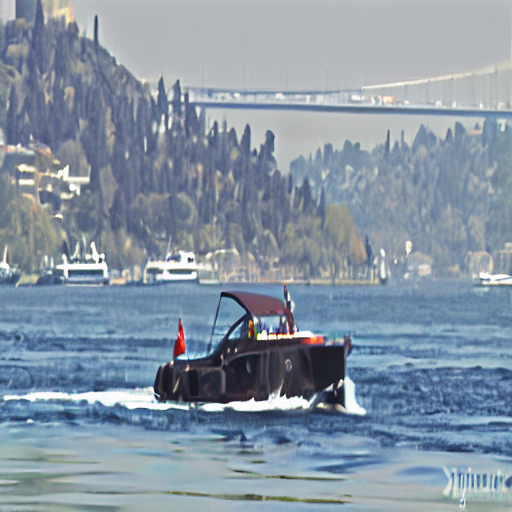

In [13]:
prompt = 'Image with high detail and sharp focus,A Yachet sailing in the ocean in front of bridge with cars , and a green mountain in background'
pipe = pipe.to("cuda")
out = pipe(prompt, sixch, flow4,guidance_scale=4.5 ,  controlnet_conditioning_scale=1.7 , )
out[0][0]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.07it/s]


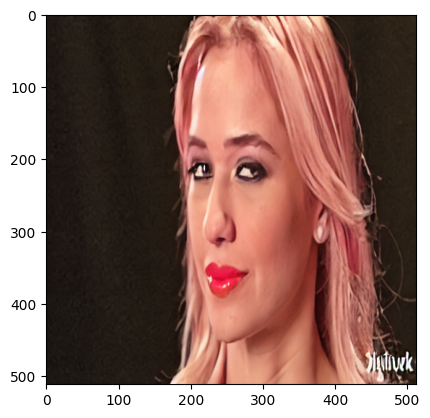

In [17]:
pipe = pipe.to("cuda")
out = pipe(prompt, sixch, flow4,guidance_scale=3.5 ,  controlnet_conditioning_scale=2, )
plt.imshow(out[0][0])
plt.savefig('fig.png')

In [16]:
plt.savefig('fig.png')

<Figure size 640x480 with 0 Axes>

100%|██████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.09it/s]


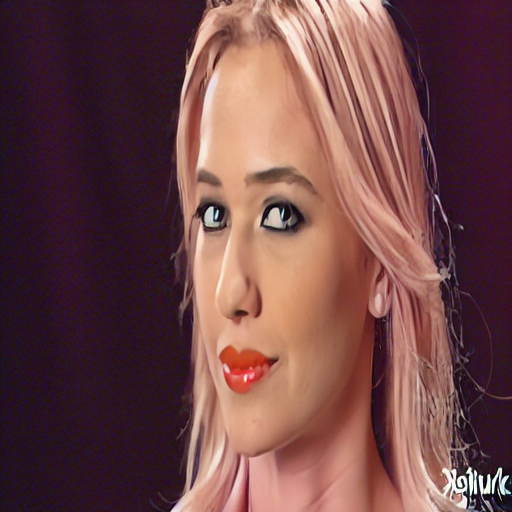

In [29]:
pipe.enable_freeu(s1=0.9, s2=0.2, b1=1.2, b2=1.4)
out = pipe(prompt, sixch, flow4,guidance_scale=4 ,  controlnet_conditioning_scale=1.85, )
out[0][0]

In [30]:
import torch
from PIL import Image
import torchvision.transforms as T
from diffusers import AutoencoderKL

device = "cuda"
dtype  = torch.float32

# --- Load the pretrained VAE ---
base = "stable-diffusion-v1-5/stable-diffusion-v1-5"
vae = AutoencoderKL.from_pretrained(base, subfolder="vae", torch_dtype=dtype).to(device)

# --- Load and preprocess image ---
path = "data/Beauty/images/frame_0000.png"
image = Image.open(path).convert("RGB")

transform = T.Compose([
    T.Resize((512, 512)),   # match training resolution
    T.ToTensor(),           # [0,1]
    T.Normalize([0.5], [0.5]),  # [-1,1]
])
img_tensor = transform(image).unsqueeze(0).to(device, dtype=dtype)  # [1,3,512,512]

# --- Encode with VAE ---
with torch.no_grad():
    posterior = vae.encode(img_tensor).latent_dist
    latents = posterior.sample() * vae.config.scaling_factor  # [1,4,64,64]

print("Latent shape:", latents.shape)



Latent shape: torch.Size([1, 4, 64, 64])


100%|██████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.15it/s]


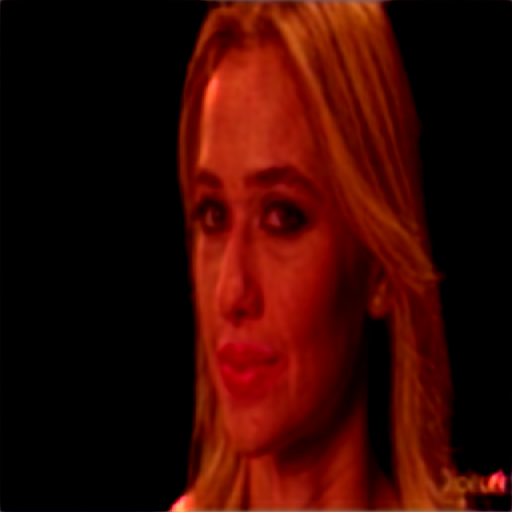

In [32]:
latents = latents * pipe.scheduler.init_noise_sigma
out = pipe(prompt, sixch, flow4,guidance_scale=4 ,  controlnet_conditioning_scale=1.85,latents =latents )
out[0][0]